## Figure 16

The classification performance metrics for
  BMC (blue), TPC (green), morphology (red), and HB (purple)
  as applied to the CFHTLenS data in the VVDS field
  with various magnitude cuts.
  The top panel shows the number of sources in the training set
  at corresponding magnitude cuts.
  We show only one of the four combination methods, BMC,
  which has the best overall performance.

In [2]:
%matplotlib inline

In [3]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('legend', fontsize=10)

In [4]:
truth_train = np.loadtxt('../../data/truth_train.dat')
truth_test = np.loadtxt('../../data/truth_test.dat')

In [5]:
# load base classifiers
mag_cut_str = ['99', '24_0', '23_5', '23_0', '22_5', '22_0', '21_5', '21_0', '20_5', '20_0']
tpc = [np.loadtxt('../../data/vvds_{0}_tpc_test.mlz'.format(i), unpack=True, usecols=(2,)) for i in mag_cut_str]
som = [np.loadtxt('../../data/vvds_{0}_som_test.mlz'.format(i), unpack=True, usecols=(2,)) for i in mag_cut_str]
hbc = [np.loadtxt('../../data/vvds_{0}_median.hbc'.format(i), unpack=True, usecols=(2,)) for i in mag_cut_str]
hbc = [i[-len(truth_test):] for i in hbc]
bmc = [np.loadtxt('../../data/vvds_{0}.bmc'.format(i), unpack=True, usecols=(0,)) for i in mag_cut_str]

In [6]:
def calc_completeness_purity(truth, classif, mag, p_cut=0.5, bins=np.arange(16, 26, 0.5)):
    '''
    '''
    # true galaxies classified as stars
    gs_bin, _ = np.histogram(mag[(classif > p_cut) & (truth == 0)], bins=bins)
    # true galaxies classified as galaxies
    gg_bin, _ = np.histogram(mag[(classif < p_cut) & (truth == 0)], bins=bins)
    # true stars classified as galaxies
    sg_bin, _ = np.histogram(mag[(classif < p_cut) & (truth == 1)], bins=bins)
    # true stars classified as stars
    ss_bin, _ = np.histogram(mag[(classif > p_cut) & (truth == 1)], bins=bins)

    # galaxy completeness
    g_comp_bin = gg_bin / (gg_bin + gs_bin)
    g_comp_bin[~np.isfinite(g_comp_bin)] = 1
    # galaxy purity
    g_pur_bin = gg_bin / (gg_bin + sg_bin)
    g_pur_bin[~np.isfinite(g_pur_bin)] = 1
    # star completeness
    s_comp_bin = ss_bin / (ss_bin + sg_bin)
    s_comp_bin[~np.isfinite(s_comp_bin)] = 1
    # star purity
    s_pur_bin = ss_bin / (ss_bin + gs_bin)
    s_pur_bin[~np.isfinite(s_pur_bin)] = 1
    
    return g_comp_bin, g_pur_bin, s_comp_bin, s_pur_bin

    
def find_purity_at(truth_test, clf, step=0.001, gc=None, sc=None):
    
    if bool(gc) == bool(sc):
        raise Exception('Specify only one of gp or sp parameter.')

    pbin = np.arange(0, 1, step)
    
    pure_all = np.zeros(len(pbin))
    comp_all = np.zeros(len(pbin))
    
    for i, p in enumerate(pbin):
        
        # true galaxies classified as stars
        gs = ((clf >= p) & (truth_test == 0)).sum()
        # true galaxies classified as galaxies
        gg = ((clf < p) & (truth_test == 0)).sum()
        # true stars classified as galaxies
        sg = ((clf < p) & (truth_test == 1)).sum()
        # true stars classified as stars
        ss = ((clf >= p) & (truth_test == 1)).sum()
    
        if gc is not None:
            if gg == 0 and gg + sg == 0:
                pure_all[i] = 1
            else:
                pure_all[i] = gg / (gg + sg)
            if gg == 0 and gg + gs == 0:
                comp_all[i] = 1
            else:
                comp_all[i] = gg / (gg + gs)
            
        if sc is not None:
            if ss == 0 and ss + sg == 0:
                comp_all[i] = 1
            else:
                comp_all[i] = ss / (ss + sg)
            if ss == 0 and ss + gs == 0:
                pure_all[i] = 1
            else:
                pure_all[i] = ss / (ss + gs)
    
    if gc is not None:
        ibin = np.argmin(np.abs(comp_all - gc))
        return pbin[ibin], pure_all[ibin]
    
    if sc is not None:
        ibin = np.argmin(np.abs(comp_all - sc))
        return pbin[ibin], pure_all[ibin]

In [7]:
from sklearn.metrics import roc_auc_score
tpc_auc = [roc_auc_score(truth_test, i) for i in tpc]
som_auc = [roc_auc_score(truth_test, i) for i in som]
hbc_auc = [roc_auc_score(truth_test, i) for i in hbc]
bmc_auc = [roc_auc_score(truth_test, i) for i in bmc]

In [8]:
from sklearn.metrics import mean_squared_error
tpc_mse = [mean_squared_error(truth_test, i) for i in tpc]
som_mse = [mean_squared_error(truth_test, i) for i in som]
hbc_mse = [mean_squared_error(truth_test, i[-len(truth_test):]) for i in hbc]
bmc_mse = [mean_squared_error(truth_test, i) for i in bmc]

In [9]:
def find_gal_pur(truth, clf, gc=0.9964, step=0.001):
    result = []
    for k in clf:
        _, j = find_purity_at(truth, k, gc=gc, step=step)
        result += [j] 
    return result

In [10]:
tpc_gpur = find_gal_pur(truth_test, tpc)

In [11]:
bmc_gpur= find_gal_pur(truth_test, bmc)

In [12]:
hbc_gpur= find_gal_pur(truth_test, hbc)

In [13]:
som_gpur= find_gal_pur(truth_test, som)

In [14]:
def find_star_pur(truth, clf, sc=0.7145, step=0.001):
    result = []
    for k in clf:
        _, j = find_purity_at(truth, k, sc=sc, step=step)
        result += [j]
    return result

In [15]:
tpc_spur = find_star_pur(truth_test, tpc)

In [16]:
bmc_spur = find_star_pur(truth_test, bmc)

In [17]:
hbc_spur = find_star_pur(truth_test, hbc)

In [18]:
som_spur = find_star_pur(truth_test, som)

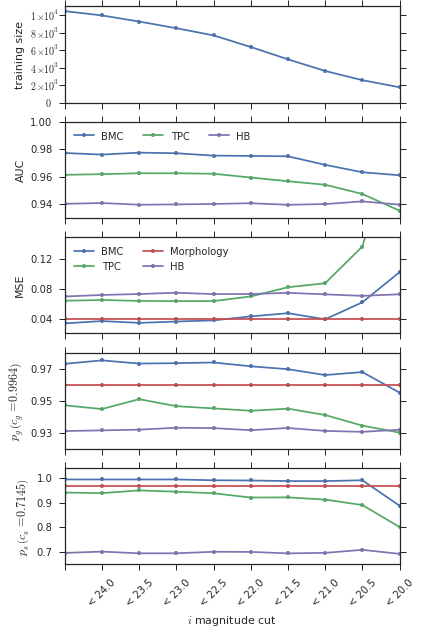

In [68]:
p = sns.color_palette()
sns.set_style("ticks")

markersize = 4

fig = plt.figure(figsize=(6, 10))
ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=3)
ax3 = plt.subplot2grid((5, 3), (2, 0), colspan=3)
ax4 = plt.subplot2grid((5, 3), (3, 0), colspan=3)
ax5 = plt.subplot2grid((5, 3), (4, 0), colspan=3)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), rotation=45)

ax1.plot([10456, 9968, 9268, 8506, 7686, 6361, 4949, 3619, 2565, 1755], ls='-', marker='o', markersize=markersize)
ax1.set_ylabel('training size')
ax1.legend(loc='upper right')
ax1.set_yticks([0, 2000, 4000, 6000, 8000, 10000])
ax1.set_yticklabels([r'$0$', r'$2 \times 10^3$', r'$4 \times 10^3$', r'$6 \times 10^3$', r'$8 \times 10^3$',
                     r'$1 \times 10^4$'])
for ticks in ax1.get_yaxis().majorTicks[1:]:
    ticks.set_pad(0)
    
ax2.plot(bmc_auc, label='BMC',
         color=p[0], ls='-', marker='o', markersize=markersize)
ax2.plot(tpc_auc, label='TPC',
         color=p[1], ls='-', marker='o', markersize=markersize)
ax2.plot(hbc_auc, label='HB',
         color=p[3], ls='-', marker='o', markersize=markersize)
ax2.set_ylim(0.93, 1.0)
ax2.set_yticks([0.94, 0.96, 0.98, 1.0])
ax2.legend(loc='upper left', ncol=3)
ax2.set_ylabel('AUC')

ax2.set_ylabel('AUC')

ax3.plot(bmc_mse, label='BMC',
         color=p[0], ls='-', marker='o', markersize=markersize)
ax3.plot(tpc_mse, label='TPC',
         color=p[1], ls='-', marker='o', markersize=markersize)
ax3.plot([0.0397] * len(tpc_mse),
         color=p[2], label='Morphology', ls='-', marker='o', markersize=markersize)
ax3.plot(hbc_mse, label='HB',
         color=p[3], ls='-', marker='o', markersize=markersize)
ax3.set_ylim(0.02, 0.15)
ax3.set_yticks([0.04, 0.08, 0.12])
ax3.set_ylabel('MSE')
ax3.legend(loc='upper left', fancybox=True, framealpha=0.5, ncol=2)

ax4.plot(bmc_gpur, label='BMC',
         color=p[0], ls='-', marker='o', markersize=markersize)
ax4.plot(tpc_gpur, label='TPC',
         color=p[1], ls='-', marker='o', markersize=markersize)
ax4.plot([0.9597] * len(tpc_gpur),
         color=p[2], label='Morphology', marker='o', markersize=markersize)
ax4.plot(hbc_gpur, label='HB',
         color=p[3], ls='-', marker='o', markersize=markersize)
ax4.set_ylim(0.92, 0.98)
ax4.set_yticks([0.93, 0.95, 0.97])
ax4.set_ylabel(r'$p_g\left(c_g=0.9964\right)$', fontsize=12)

ax5.plot(bmc_spur, label='BMC',
         color=p[0], ls='-', marker='o', markersize=markersize)
ax5.plot(tpc_spur, label='TPC',
         color=p[1], ls='-', marker='o', markersize=markersize)
ax5.plot([0.9666] * len(tpc_spur),
         color=p[2], label='Morphology', ls='-', marker='o', markersize=markersize)
ax5.plot(hbc_spur, label='HB',
         color=p[3], ls='-', marker='o', markersize=markersize)
ax5.set_ylim(0.65, 1.04)
ax5.set_yticks([0.7, 0.8, 0.9, 1.0])
ax5.set_ylabel(r'$p_s\left(c_s=0.7145\right)$', fontsize=12)

ax5.set_xticklabels(['', '< 24.0', '< 23.5', '< 23.0', '< 22.5',
                     '< 22.0', '< 21.5', '< 21.0', '< 20.5', '< 20.0'])
ax5.set_xlabel(r'$i$ magnitude cut')

plt.savefig('../../figures/perform_mag_cut.pdf')
plt.show()